# Imports

In [1]:
import pandas as pd
import numpy as np
import spacy
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Setup

In [2]:
# Set seed
np.random.seed(42)

# Set the font size of the plots
plt.rcParams.update({'font.size': 14})

# Read data

In [3]:
df_train = pd.read_csv("sample_size_train.csv")
df_test = pd.read_csv("sample_size_test.csv")

# Characteristics

In [4]:
df_test.describe()  

,_input_hash,_task_hash,_timestamp,Number_randomized
count,1.500000e+02,1.500000e+02,1.500000e+02,150.000000
mean,-1.762514e+07,2.059199e+08,1.698734e+09,4576.480000
std,1.285986e+09,1.178720e+09,1.454310e+05,15795.988117
min,-2.128263e+09,-2.145153e+09,1.698574e+09,20.000000
25%,-1.192276e+09,-7.455020e+08,1.698598e+09,304.000000
50%,1.217776e+08,3.428295e+08,1.698674e+09,781.000000
75%,1.128677e+09,1.234889e+09,1.698843e+09,2518.500000
max,2.105276e+09,2.115686e+09,1.699011e+09,159688.000000


# Testing

In [5]:
# Load model
sample_size_model = spacy.load("./sample_size_v1/model-best")

# Use GPU for prediction
spacy.require_gpu()


/Users/paulwindisch/opt/anaconda3/envs/journal_nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Predict sample sizes:

In [6]:
def predict_sample_sizes(row):
    """Predicts the sample size entities in the abstract of the given row.

    :param row: The row of the dataframe
    :type row: pandas.core.series.Series
    :return: The predicted sample size entities.
    :rtype: dict
    """

    abstract = row["text"]
    entities = {
        "RANDOMIZED_TOTAL": [],
        "ANALYSIS_TOTAL": [],
        "COMPLETION_TOTAL": [],
        "GENERAL_TOTAL": [],
        "ARM": [],
        "ARM_EVENT": [],
    }
    for entity in sample_size_model(abstract).ents:
        try:
            if entity.label_ == "RANDOMIZED_TOTAL":
                entities["RANDOMIZED_TOTAL"].append(entity.text)
            if entity.label_ == "ANALYSIS_TOTAL":
                entities["ANALYSIS_TOTAL"].append(entity.text)
            if entity.label_ == "COMPLETION_TOTAL":
                entities["COMPLETION_TOTAL"].append(entity.text)
            if entity.label_ == "GENERAL_TOTAL":
                entities["GENERAL_TOTAL"].append(entity.text)
            if entity.label_ == "ARM":
                entities["ARM"].append(entity.text)
            if entity.label_ == "ARM_EVENT":
                entities["ARM_EVENT"].append(entity.text)
        except:
            pass
    return entities

df_test["sample_sizes"] = df_test.apply(predict_sample_sizes, axis=1)

## Clean sample size prediction

In [7]:
# Define words that represent numbers
numberwords = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "ten",
    "eleven",
    "twelve",
    "thirteen",
    "fourteen",
    "fifteen",
    "sixteen",
    "seventeen",
    "eighteen",
    "nineteen",
    "twenty",
    "thirty",
    "forty",
    "fifty",
    "sixty",
    "seventy",
    "eighty",
    "ninety",
    "hundred",
    "thousand",
    "million",
    "billion",
    "trillion",
]


# Define a function to create number from words (taken from https://stackoverflow.com/questions/493174/is-there-a-way-to-convert-number-words-to-integers)
def text2int(textnum, numwords={}):
    if not numwords:
        units = [
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "ten",
            "eleven",
            "twelve",
            "thirteen",
            "fourteen",
            "fifteen",
            "sixteen",
            "seventeen",
            "eighteen",
            "nineteen",
        ]

        tens = [
            "",
            "",
            "twenty",
            "thirty",
            "forty",
            "fifty",
            "sixty",
            "seventy",
            "eighty",
            "ninety",
        ]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):
            numwords[word] = (1, idx)
        for idx, word in enumerate(tens):
            numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales):
            numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
            raise Exception("Illegal word: " + word)

        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current


def clean_sample_size_dicts(cell):
    """Cleans the sample size dictionaries by turning raw sample sizes into numbers.

    :param cell: The cell of the dataframe
    :type cell: pandas.core.series.Series
    :return: Row with the cleaned sample size dictionaries
    :rtype: pandas.core.series.Series
    """
    if type(cell) == dict:
        new_cell = {}
        for key, value_list in cell.items():
            new_value_list = []
            for value in value_list:
                # Remove "n=" from strings
                if re.search(r"n=", value):
                    value = value.replace("n=", "")
                # Remove "\u202f" from strings
                if re.search(r"\u202f", value):
                    value = value.replace("\u202f", "")
                # Find number words in strings and convert them to numbers
                if re.search(r"\D+", value):
                    word_list = re.findall(r"\w+", value)
                    word_list = [word.lower() for word in word_list]
                    found_number_words = ""
                    for word in word_list:
                        if word in numberwords:
                            found_number_words += word + " "
                        else:
                            break
                    if found_number_words != "":
                        new_value = text2int(found_number_words)
                        new_value_list.append(new_value)
                        continue
                # Remove commas and spaces from strings
                if re.search(r"\D+", value):
                    if re.search(r",", value):
                        value = re.sub(r",", "", value)
                    if re.search(r"\s", value):
                        value = re.sub(r"\s", "", value)
                new_value_list.append(value)
                # Convert strings to numbers
            new_value_list_as_ints = []
            for new_value in new_value_list:
                try:
                    new_value_list_as_ints.append(int(new_value))
                except:
                    print(f"Removed: {new_value}")
            new_cell[key] = new_value_list_as_ints
        return new_cell


df_test["cleaned_sample_sizes_"] = df_test["sample_sizes"].apply(
    clean_sample_size_dicts
)

Removed: 4675/6248
Removed: 6248of20


In [8]:
# Create columns for each sample size type
df_test["RANDOMIZED_TOTAL"] = df_test["cleaned_sample_sizes_"].apply(
    lambda x: x.get("RANDOMIZED_TOTAL", [])
)
df_test["ANALYSIS_TOTAL"] = df_test["cleaned_sample_sizes_"].apply(
    lambda x: x.get("ANALYSIS_TOTAL", [])
)
df_test["COMPLETION_TOTAL"] = df_test["cleaned_sample_sizes_"].apply(
    lambda x: x.get("COMPLETION_TOTAL", [])
)
df_test["GENERAL_TOTAL"] = df_test["cleaned_sample_sizes_"].apply(
    lambda x: x.get("GENERAL_TOTAL", [])
)
df_test["ARM"] = df_test["cleaned_sample_sizes_"].apply(lambda x: x.get("ARM", []))
df_test["ARM_EVENT"] = df_test["cleaned_sample_sizes_"].apply(
    lambda x: x.get("ARM_EVENT", [])
)


In [9]:
# Check how many sample sizes were found
print(
    f"Found {len(df_test[df_test['RANDOMIZED_TOTAL'].apply(len) > 0])} randomized total sample sizes."
)
print(
    f"Found {len(df_test[df_test['ANALYSIS_TOTAL'].apply(len) > 0])} analysis total sample sizes."
)
print(
    f"Found {len(df_test[df_test['COMPLETION_TOTAL'].apply(len) > 0])} completion total sample sizes."
)
print(
    f"Found {len(df_test[df_test['GENERAL_TOTAL'].apply(len) > 0])} general total sample sizes."
)
print(f"Found {len(df_test[df_test['ARM'].apply(len) > 0])} arm sample sizes.")
print(
    f"Found {len(df_test[df_test['ARM_EVENT'].apply(len) > 0])} arm event sample sizes."
)


Found 63 randomized total sample sizes.
Found 19 analysis total sample sizes.
Found 30 completion total sample sizes.
Found 98 general total sample sizes.
Found 111 arm sample sizes.
Found 59 arm event sample sizes.


In [10]:
# Check how what percentage of the sample sizes are found
print(
    f"Found {len(df_test[df_test['RANDOMIZED_TOTAL'].apply(len) > 0]) / len(df_test) * 100:.2f}% of the randomized total sample sizes."
)
print(
    f"Found {len(df_test[df_test['ANALYSIS_TOTAL'].apply(len) > 0]) / len(df_test) * 100:.2f}% of the analysis total sample sizes."
)
print(
    f"Found {len(df_test[df_test['COMPLETION_TOTAL'].apply(len) > 0]) / len(df_test) * 100:.2f}% of the completion total sample sizes."
)
print(
    f"Found {len(df_test[df_test['GENERAL_TOTAL'].apply(len) > 0]) / len(df_test) * 100:.2f}% of the general total sample sizes."
)
print(
    f"Found {len(df_test[df_test['ARM'].apply(len) > 0]) / len(df_test) * 100:.2f}% of the arm sample sizes."
)
print(
    f"Found {len(df_test[df_test['ARM_EVENT'].apply(len) > 0]) / len(df_test) * 100:.2f}% of the arm event sample sizes."
)


Found 42.00% of the randomized total sample sizes.
Found 12.67% of the analysis total sample sizes.
Found 20.00% of the completion total sample sizes.
Found 65.33% of the general total sample sizes.
Found 74.00% of the arm sample sizes.
Found 39.33% of the arm event sample sizes.


In [11]:
# Create maximum sample size columns
df_test["RANDOMIZED_TOTAL_MAX"] = df_test["RANDOMIZED_TOTAL"].apply(
    lambda x: max(x) if len(x) > 0 else None
)
df_test["ANALYSIS_TOTAL_MAX"] = df_test["ANALYSIS_TOTAL"].apply(
    lambda x: max(x) if len(x) > 0 else None
)
df_test["COMPLETION_TOTAL_MAX"] = df_test["COMPLETION_TOTAL"].apply(
    lambda x: max(x) if len(x) > 0 else None
)
df_test["GENERAL_TOTAL_MAX"] = df_test["GENERAL_TOTAL"].apply(
    lambda x: max(x) if len(x) > 0 else None
)

# For the ARM and ARM_EVENT columns, calculate the sum of the sample sizes
df_test["ARM_SUM"] = df_test["ARM"].apply(lambda x: sum(x) if len(x) > 0 else None)
df_test["ARM_EVENT_SUM"] = df_test["ARM_EVENT"].apply(
    lambda x: sum(x) if len(x) > 0 else None
)

## Accuracy of the raw predictions

### Randomized total

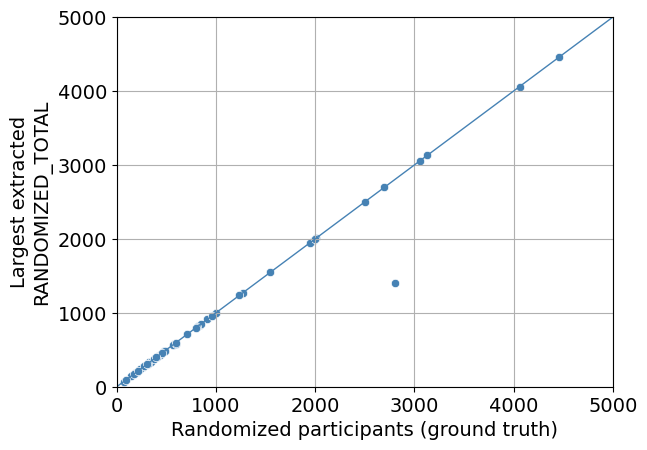

In [12]:
# Create a scatter plot of the randomized total sample sizes and the ground truth
scatterplot_randomized_total = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="RANDOMIZED_TOTAL_MAX",
    color="steelblue",

)

scatterplot_randomized_total.set_xlim(
    0,5000
)
scatterplot_randomized_total.set_ylim(
    0,5000
)
scatterplot_randomized_total.set_xlabel("Randomized participants (ground truth)")
scatterplot_randomized_total.set_ylabel("Largest extracted\nRANDOMIZED_TOTAL")


# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_randomized_total.png", dpi=300, bbox_inches="tight")

plt.show()

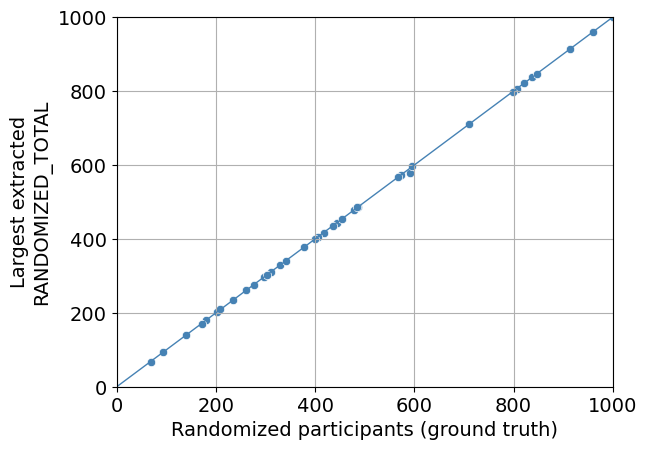

In [13]:
# Zoom in on the scatter plot

scatterplot_randomized_total_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="RANDOMIZED_TOTAL_MAX",
    color="steelblue",
)

scatterplot_randomized_total_zoom.set_xlim(0, 1000)
scatterplot_randomized_total_zoom.set_ylim(0, 1000)

scatterplot_randomized_total_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_randomized_total_zoom.set_ylabel("Largest extracted\nRANDOMIZED_TOTAL")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_randomized_total_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [14]:
# Calculate the mean absolute percentage error for the randomized total sample sizes
df_test["RANDOMIZED_TOTAL_MAX_APE"] = (
    abs(df_test["RANDOMIZED_TOTAL_MAX"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)
print(
    f"Mean absolute percentage error for randomized total sample sizes: {df_test['RANDOMIZED_TOTAL_MAX_APE'].mean():.1%}"
)

print(f"Median absolute percentage error for randomized total sample sizes: {df_test['RANDOMIZED_TOTAL_MAX_APE'].median():.1%}")

Mean absolute percentage error for randomized total sample sizes: 2.4%
Median absolute percentage error for randomized total sample sizes: 0.0%


In [15]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["RANDOMIZED_TOTAL_MAX_WITHIN_1_PERCENT"] = df_test[
    "RANDOMIZED_TOTAL_MAX_APE"
] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["RANDOMIZED_TOTAL_MAX_WITHIN_10_PERCENT"] = df_test[
    "RANDOMIZED_TOTAL_MAX_APE"
] < 0.1
# Calculate the percentage of exact matches
df_test["RANDOMIZED_TOTAL_MAX_EXACT"] = df_test["RANDOMIZED_TOTAL_MAX_APE"] == 0

number_within_1_percent = df_test["RANDOMIZED_TOTAL_MAX_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["RANDOMIZED_TOTAL_MAX_WITHIN_10_PERCENT"].sum()
number_exact = df_test["RANDOMIZED_TOTAL_MAX_EXACT"].sum()
total_trials_with_randomized_total = len(df_test[df_test["RANDOMIZED_TOTAL_MAX"].notnull()])

print(
    f"Percentage of extracted randomized total sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_randomized_total:.1%}"
)
print(
    f"Percentage of extracted randomized total sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_randomized_total:.1%}"
)
print(
    f"Percentage of exact matches for extracted randomized total sample sizes: {number_exact/total_trials_with_randomized_total:.1%}"
)

Percentage of extracted randomized total sample sizes within 1% of the ground truth: 95.2%
Percentage of extracted randomized total sample sizes within 10% of the ground truth: 96.8%
Percentage of exact matches for extracted randomized total sample sizes: 95.2%


### Analysis total

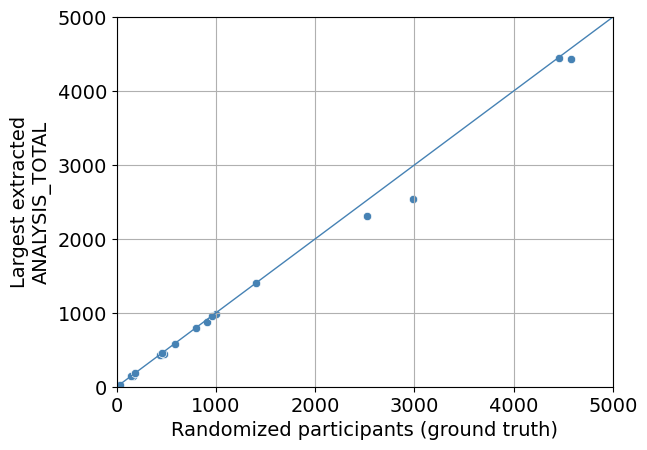

In [16]:
# Create a scatter plot of the analysis total sample sizes and the ground truth
scatterplot_analysis_total = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="ANALYSIS_TOTAL_MAX",
    color="steelblue",
)

scatterplot_analysis_total.set_xlim(
    0,5000
)
scatterplot_analysis_total.set_ylim(
    0,5000
)

scatterplot_analysis_total.set_xlabel("Randomized participants (ground truth)")
scatterplot_analysis_total.set_ylabel("Largest extracted\nANALYSIS_TOTAL")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_analysis_total.png", dpi=300, bbox_inches="tight")

plt.show()

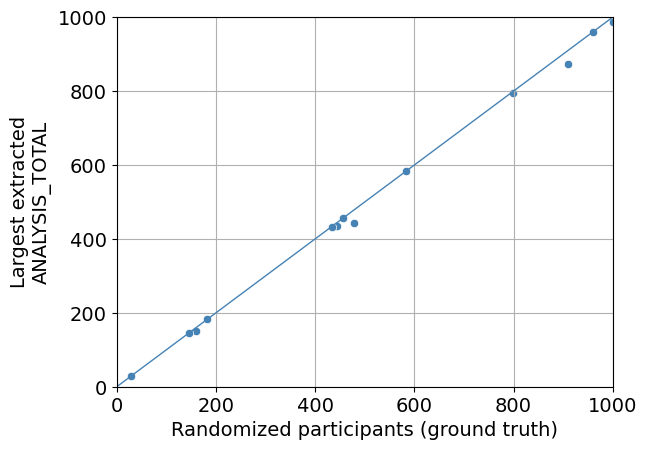

In [17]:
# Zoom in on the scatter plot
scatterplot_analysis_total_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="ANALYSIS_TOTAL_MAX",
    color="steelblue",
)

scatterplot_analysis_total_zoom.set_xlim(0, 1000)
scatterplot_analysis_total_zoom.set_ylim(0, 1000)

scatterplot_analysis_total_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_analysis_total_zoom.set_ylabel("Largest extracted\nANALYSIS_TOTAL")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_analysis_total_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [18]:
# Calculate the mean absolute percentage error for the analysis total sample sizes
df_test["ANALYSIS_TOTAL_MAX_APE"] = (
    abs(df_test["ANALYSIS_TOTAL_MAX"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)
print(
    f"Mean absolute percentage error for analysis total sample sizes: {df_test['ANALYSIS_TOTAL_MAX_APE'].mean():.1%}"
)

print(f"Median absolute percentage error for analysis total sample sizes: {df_test['ANALYSIS_TOTAL_MAX_APE'].median():.1%}")


Mean absolute percentage error for analysis total sample sizes: 3.1%
Median absolute percentage error for analysis total sample sizes: 1.3%


In [19]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["ANALYSIS_TOTAL_MAX_WITHIN_1_PERCENT"] = df_test[
    "ANALYSIS_TOTAL_MAX_APE"
] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["ANALYSIS_TOTAL_MAX_WITHIN_10_PERCENT"] = df_test[
    "ANALYSIS_TOTAL_MAX_APE"
] < 0.1
# Calculate the percentage of exact matches
df_test["ANALYSIS_TOTAL_MAX_EXACT"] = df_test["ANALYSIS_TOTAL_MAX_APE"] == 0

number_within_1_percent = df_test["ANALYSIS_TOTAL_MAX_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["ANALYSIS_TOTAL_MAX_WITHIN_10_PERCENT"].sum()
number_exact = df_test["ANALYSIS_TOTAL_MAX_EXACT"].sum()
total_trials_with_analysis_total = len(df_test[df_test["ANALYSIS_TOTAL_MAX"].notnull()])
print(
    f"Percentage of extracted analysis total sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_analysis_total:.1%}"
)
print(
    f"Percentage of extracted analysis total sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_analysis_total:.1%}"
)
print(
    f"Percentage of exact matches for extracted analysis total sample sizes: {number_exact/total_trials_with_analysis_total:.1%}"
)


Percentage of extracted analysis total sample sizes within 1% of the ground truth: 47.4%
Percentage of extracted analysis total sample sizes within 10% of the ground truth: 94.7%
Percentage of exact matches for extracted analysis total sample sizes: 26.3%


### Completion total

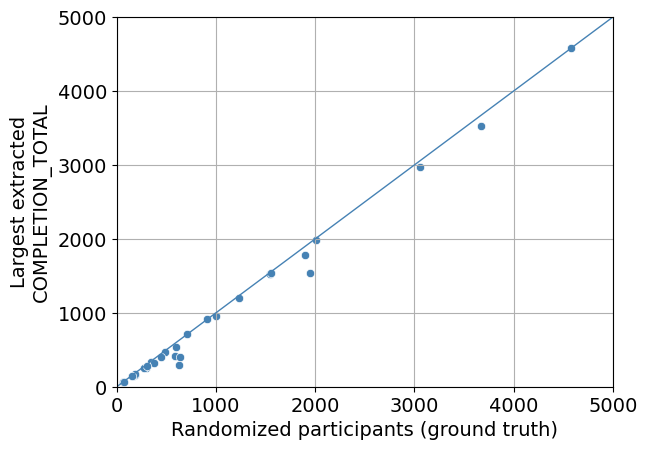

In [20]:
# Create a scatter plot of the completion total sample sizes and the ground truth
scatterplot_completion_total = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="COMPLETION_TOTAL_MAX",
    color="steelblue",
)

scatterplot_completion_total.set_xlim(
    0,5000
)
scatterplot_completion_total.set_ylim(
    0,5000
)

scatterplot_completion_total.set_xlabel("Randomized participants (ground truth)")
scatterplot_completion_total.set_ylabel("Largest extracted\nCOMPLETION_TOTAL")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_completion_total.png", dpi=300, bbox_inches="tight")

plt.show()

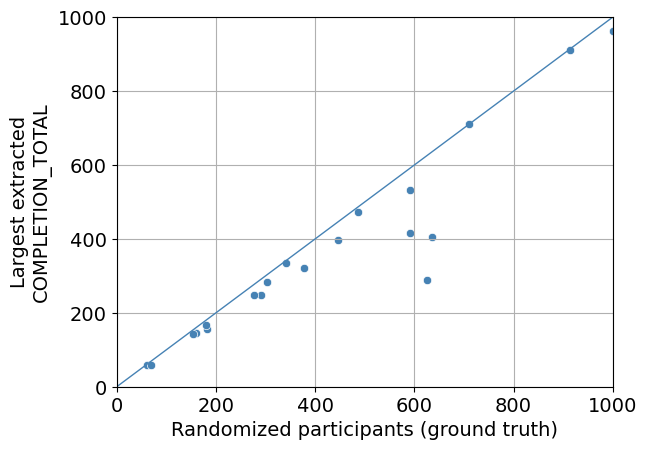

In [21]:
# Zoom in on the scatter plot
scatterplot_completion_total_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="COMPLETION_TOTAL_MAX",
    color="steelblue",
)

scatterplot_completion_total_zoom.set_xlim(0, 1000)
scatterplot_completion_total_zoom.set_ylim(0, 1000)

scatterplot_completion_total_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_completion_total_zoom.set_ylabel("Largest extracted\nCOMPLETION_TOTAL")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_completion_total_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [22]:
# Calculate the mean absolute percentage error for the completion total sample sizes
df_test["COMPLETION_TOTAL_MAX_APE"] = (
    abs(df_test["COMPLETION_TOTAL_MAX"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)
print(
    f"Mean absolute percentage error for completion total sample sizes: {df_test['COMPLETION_TOTAL_MAX_APE'].mean():.1%}"
)

print(f"Median absolute percentage error for completion total sample sizes: {df_test['COMPLETION_TOTAL_MAX_APE'].median():.1%}")


Mean absolute percentage error for completion total sample sizes: 9.5%
Median absolute percentage error for completion total sample sizes: 6.2%


In [23]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["COMPLETION_TOTAL_MAX_WITHIN_1_PERCENT"] = df_test[
    "COMPLETION_TOTAL_MAX_APE"
] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["COMPLETION_TOTAL_MAX_WITHIN_10_PERCENT"] = df_test[
    "COMPLETION_TOTAL_MAX_APE"
] < 0.1
# Calculate the percentage of exact matches
df_test["COMPLETION_TOTAL_MAX_EXACT"] = df_test["COMPLETION_TOTAL_MAX_APE"] == 0

number_within_1_percent = df_test["COMPLETION_TOTAL_MAX_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["COMPLETION_TOTAL_MAX_WITHIN_10_PERCENT"].sum()
number_exact = df_test["COMPLETION_TOTAL_MAX_EXACT"].sum()
total_trials_with_completion_total = len(df_test[df_test["COMPLETION_TOTAL_MAX"].notnull()])

print(
    f"Percentage of extracted completion total sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_completion_total:.1%}"
)
print(
    f"Percentage of extracted completion total sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_completion_total:.1%}"
)
print(
    f"Percentage of exact matches for extracted completion total sample sizes: {number_exact/total_trials_with_completion_total:.1%}"
)

Percentage of extracted completion total sample sizes within 1% of the ground truth: 20.0%
Percentage of extracted completion total sample sizes within 10% of the ground truth: 70.0%
Percentage of exact matches for extracted completion total sample sizes: 10.0%


### General total

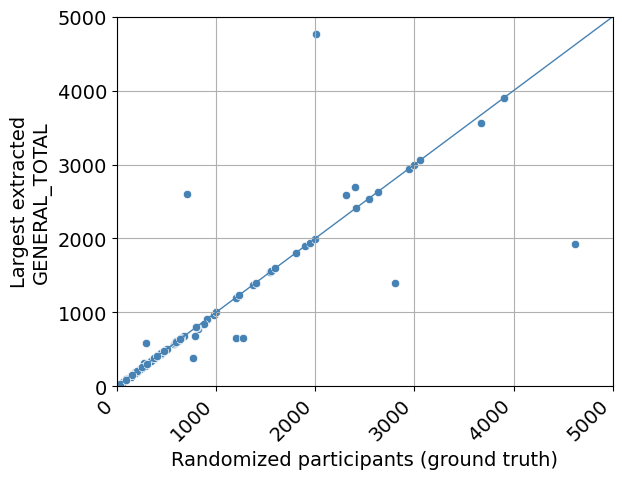

In [24]:
# Create a scatter plot of the general total sample sizes and the ground truth
scatterplot_general_total = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="GENERAL_TOTAL_MAX",
    color="steelblue",
)

scatterplot_general_total.set_xlim(
    0,5000
)
scatterplot_general_total.set_ylim(
    0,5000
)

scatterplot_general_total.set_xlabel("Randomized participants (ground truth)")
scatterplot_general_total.set_ylabel("Largest extracted\nGENERAL_TOTAL")

plt.xticks(rotation=45, ha="right")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_general_total.png", dpi=300, bbox_inches="tight")

plt.show()

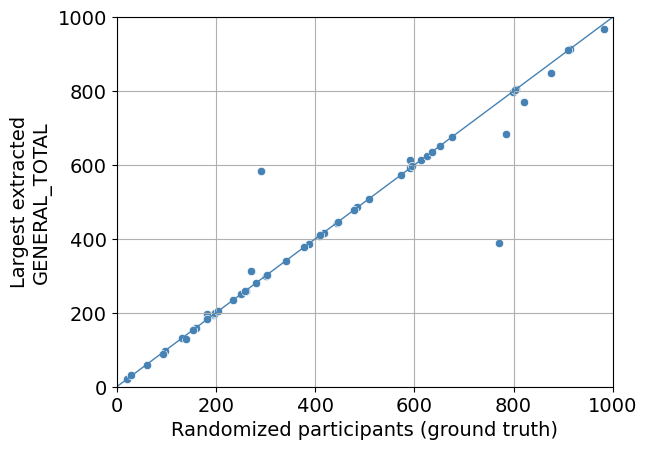

In [25]:
# Zoom in on the scatter plot
scatterplot_general_total_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="GENERAL_TOTAL_MAX",
    color="steelblue",
)

scatterplot_general_total_zoom.set_xlim(0, 1000)
scatterplot_general_total_zoom.set_ylim(0, 1000)

scatterplot_general_total_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_general_total_zoom.set_ylabel("Largest extracted\nGENERAL_TOTAL")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_general_total_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [26]:
# Calculate the mean absolute percentage error for the general total sample sizes
df_test["GENERAL_TOTAL_MAX_APE"] = (
    abs(df_test["GENERAL_TOTAL_MAX"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)
print(
    f"Mean absolute percentage error for general total sample sizes: {df_test['GENERAL_TOTAL_MAX_APE'].mean():.1%}"
)

print(f"Median absolute percentage error for general total sample sizes: {df_test['GENERAL_TOTAL_MAX_APE'].median():.1%}")

Mean absolute percentage error for general total sample sizes: 19.0%
Median absolute percentage error for general total sample sizes: 0.0%


In [27]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["GENERAL_TOTAL_MAX_WITHIN_1_PERCENT"] = df_test[
    "GENERAL_TOTAL_MAX_APE"
] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["GENERAL_TOTAL_MAX_WITHIN_10_PERCENT"] = df_test[
    "GENERAL_TOTAL_MAX_APE"
] < 0.1
# Calculate the percentage of exact matches
df_test["GENERAL_TOTAL_MAX_EXACT"] = df_test["GENERAL_TOTAL_MAX_APE"] == 0

number_within_1_percent = df_test["GENERAL_TOTAL_MAX_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["GENERAL_TOTAL_MAX_WITHIN_10_PERCENT"].sum()
number_exact = df_test["GENERAL_TOTAL_MAX_EXACT"].sum()
total_trials_with_general_total = len(df_test[df_test["GENERAL_TOTAL_MAX"].notnull()])

print(
    f"Percentage of extracted general total sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_general_total:.1%}"
)
print(
    f"Percentage of extracted general total sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_general_total:.1%}"
)
print(
    f"Percentage of exact matches for extracted general total sample sizes: {number_exact/total_trials_with_general_total:.1%}"
)

Percentage of extracted general total sample sizes within 1% of the ground truth: 74.5%
Percentage of extracted general total sample sizes within 10% of the ground truth: 85.7%
Percentage of exact matches for extracted general total sample sizes: 70.4%


### Arms

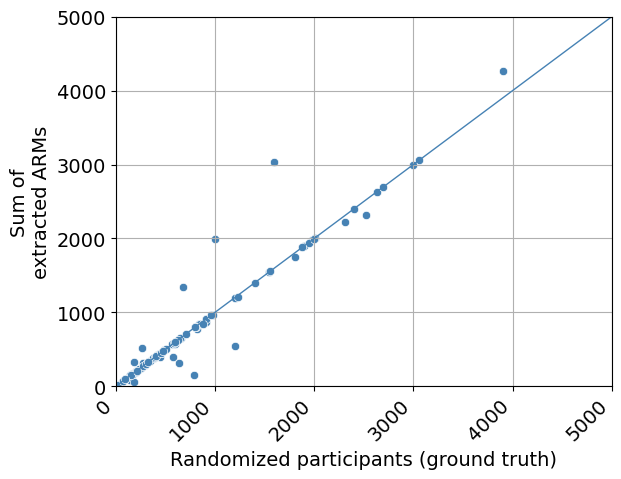

In [28]:
# Create a scatter plot of the arm sample sizes and the ground truth
scatterplot_arm = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="ARM_SUM",
    color="steelblue",
)

scatterplot_arm.set_xlim(
    0,5000
)
scatterplot_arm.set_ylim(
    0,5000
)

scatterplot_arm.set_xlabel("Randomized participants (ground truth)")
scatterplot_arm.set_ylabel("Sum of\nextracted ARMs")

plt.xticks(rotation=45, ha="right")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_arm.png", dpi=300, bbox_inches="tight")

plt.show()

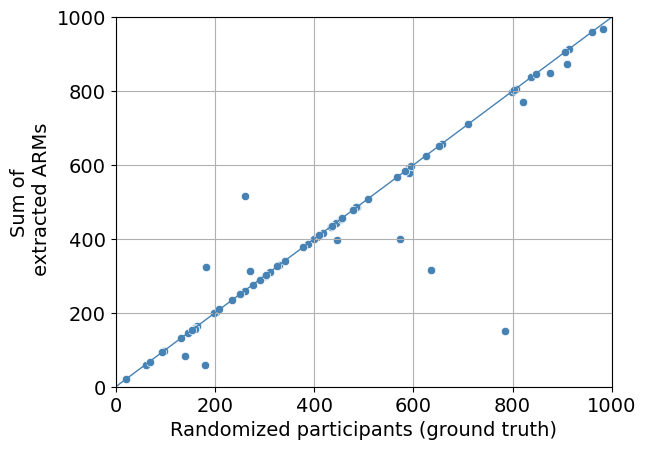

In [29]:
# Zoom in on the scatter plot
scatterplot_arm_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="ARM_SUM",
    color="steelblue",
)

scatterplot_arm_zoom.set_xlim(0, 1000)
scatterplot_arm_zoom.set_ylim(0, 1000)

scatterplot_arm_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_arm_zoom.set_ylabel("Sum of\n extracted ARMs")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_arm_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [30]:
# Calculate the mean absolute percentage error for the arm sample sizes
df_test["ARM_SUM_APE"] = (
    abs(df_test["ARM_SUM"] - df_test["Number_randomized"]) / df_test["Number_randomized"]
)
print(f"Mean absolute percentage error for arm sample sizes: {df_test['ARM_SUM_APE'].mean():.1%}")

print(f"Median absolute percentage error for arm sample sizes: {df_test['ARM_SUM_APE'].median():.1%}")

Mean absolute percentage error for arm sample sizes: 11.1%
Median absolute percentage error for arm sample sizes: 0.0%


In [31]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["ARM_SUM_WITHIN_1_PERCENT"] = df_test["ARM_SUM_APE"] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["ARM_SUM_WITHIN_10_PERCENT"] = df_test["ARM_SUM_APE"] < 0.1
# Calculate the percentage of exact matches
df_test["ARM_SUM_EXACT"] = df_test["ARM_SUM_APE"] == 0

number_within_1_percent = df_test["ARM_SUM_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["ARM_SUM_WITHIN_10_PERCENT"].sum()
number_exact = df_test["ARM_SUM_EXACT"].sum()
total_trials_with_arm = len(df_test[df_test["ARM_SUM"].notnull()])

print(
    f"Percentage of extracted arm sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_arm:.1%}"
)
print(
    f"Percentage of extracted arm sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_arm:.1%}"
)
print(
    f"Percentage of exact matches for extracted arm sample sizes: {number_exact/total_trials_with_arm:.1%}"
)

Percentage of extracted arm sample sizes within 1% of the ground truth: 71.2%
Percentage of extracted arm sample sizes within 10% of the ground truth: 82.9%
Percentage of exact matches for extracted arm sample sizes: 66.7%


### Arm event

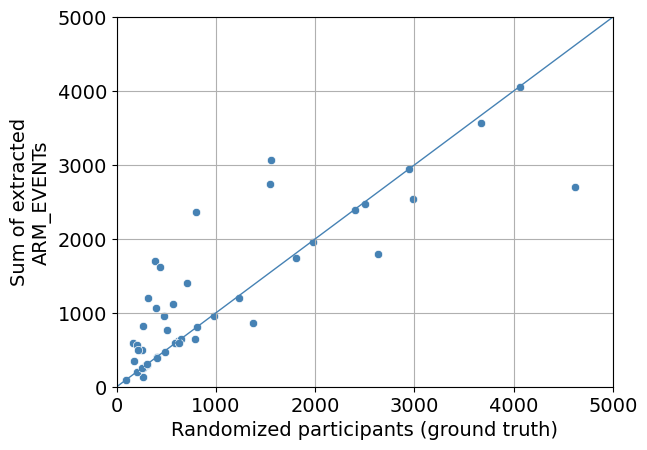

In [32]:
# Create a scatter plot of the arm event sample sizes and the ground truth
scatterplot_arm_event = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="ARM_EVENT_SUM",
    color="steelblue",
)

scatterplot_arm_event.set_xlim(
    0,5000
)
scatterplot_arm_event.set_ylim(
    0,5000
)

scatterplot_arm_event.set_xlabel("Randomized participants (ground truth)")
scatterplot_arm_event.set_ylabel("Sum of extracted\nARM_EVENTs")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_arm_event.png", dpi=300, bbox_inches="tight")

plt.show()

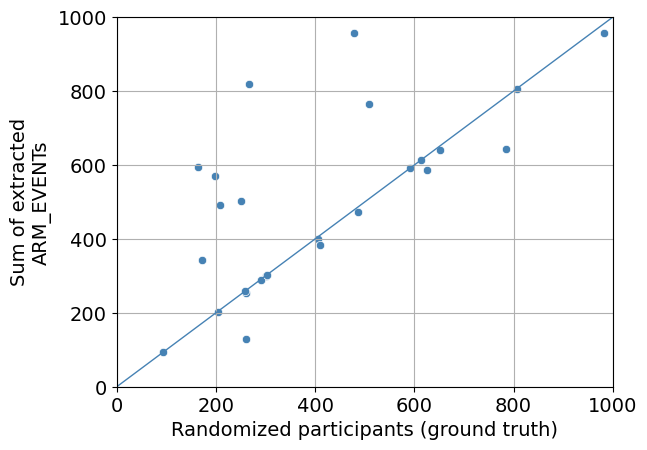

In [33]:
# Zoom in on the scatter plot
scatterplot_arm_event_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="ARM_EVENT_SUM",
    color="steelblue",
)

scatterplot_arm_event_zoom.set_xlim(0, 1000)
scatterplot_arm_event_zoom.set_ylim(0, 1000)

scatterplot_arm_event_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_arm_event_zoom.set_ylabel("Sum of extracted\nARM_EVENTs")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_arm_event_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [34]:
# Calculate the mean absolute percentage error for the arm event sample sizes
df_test["ARM_EVENT_SUM_APE"] = (
    abs(df_test["ARM_EVENT_SUM"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)
print(
    f"Mean absolute percentage error for arm event sample sizes: {df_test['ARM_EVENT_SUM_APE'].mean():.1%}"
)

print(f"Median absolute percentage error for arm event sample sizes: {df_test['ARM_EVENT_SUM_APE'].median():.1%}")

Mean absolute percentage error for arm event sample sizes: 61.7%
Median absolute percentage error for arm event sample sizes: 7.0%


In [35]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["ARM_EVENT_SUM_WITHIN_1_PERCENT"] = df_test["ARM_EVENT_SUM_APE"] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["ARM_EVENT_SUM_WITHIN_10_PERCENT"] = df_test["ARM_EVENT_SUM_APE"] < 0.1
# Calculate the percentage of exact matches
df_test["ARM_EVENT_SUM_EXACT"] = df_test["ARM_EVENT_SUM_APE"] == 0

number_within_1_percent = df_test["ARM_EVENT_SUM_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["ARM_EVENT_SUM_WITHIN_10_PERCENT"].sum()
number_exact = df_test["ARM_EVENT_SUM_EXACT"].sum()
total_trials_with_arm_event = len(df_test[df_test["ARM_EVENT_SUM"].notnull()])

print(
    f"Percentage of extracted arm event sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_arm_event:.1%}"
)
print(
    f"Percentage of extracted arm event sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_arm_event:.1%}"
)
print(
    f"Percentage of exact matches for extracted arm event sample sizes: {number_exact/total_trials_with_arm_event:.1%}"
)

Percentage of extracted arm event sample sizes within 1% of the ground truth: 27.1%
Percentage of extracted arm event sample sizes within 10% of the ground truth: 50.8%
Percentage of exact matches for extracted arm event sample sizes: 20.3%


# Ordering for combined prediction

In [36]:
def create_number_randomized_prediction(row):
    """Creates the sample size prediction based on the extracted sample sizes.

    :param row: The row of the dataframe
    :type row: pandas.core.series.Series
    :return: The predicted sample size.
    :rtype: int
    """

    randomized_total = row["RANDOMIZED_TOTAL"]
    analysis_total = row["ANALYSIS_TOTAL"]
    completion_total = row["COMPLETION_TOTAL"]
    general_total = row["GENERAL_TOTAL"]
    arms = row["ARM"]
    arm_events = row["ARM_EVENT"]

    # Use the maximum randomized total if present
    if len(randomized_total) > 0:
        return max(randomized_total)
    
    # Use the sum of the arms if present
    if len(arms) > 0:
        return sum(arms)
    
    # Use the maximum general total if present
    if len(general_total) > 0:
        return max(general_total)
    
    # Use the analysis total if present
    if len(analysis_total) > 0:
        return max(analysis_total)
    
    # Use the completion total if present
    if len(completion_total) > 0:
        return max(completion_total)
    
    # Use the sum of the arm events if present
    if len(arm_events) > 0:
        return sum(arm_events)
    
    # If no sample size is found, return None
    return None
    




    
df_test["Number_randomized_prediction_ordered_model"] = df_test.apply(create_number_randomized_prediction, axis=1)

In [37]:
# Calculate how many predictions were made
print(f"Predicted {len(df_test[df_test['Number_randomized_prediction_ordered_model'].notnull()])} sample sizes.")

# Calculate how many predictions were made in %
print(f"Predicted {len(df_test[df_test['Number_randomized_prediction_ordered_model'].notnull()]) / len(df_test) * 100:.1f}% of sample sizes.")

Predicted 147 sample sizes.
Predicted 98.0% of sample sizes.


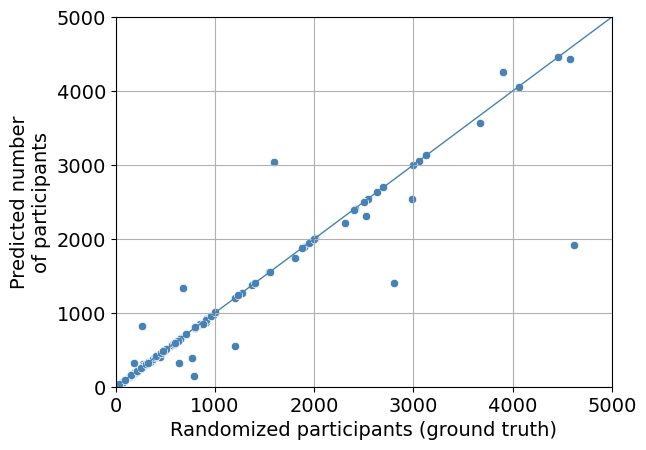

In [38]:
# Create a scatterplot for the ordered model
scatterplot_ordered_model = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="Number_randomized_prediction_ordered_model",
    color="steelblue",
)

scatterplot_ordered_model.set_xlim(
    0,5000
)
scatterplot_ordered_model.set_ylim(
    0,5000
)

scatterplot_ordered_model.set_xlabel("Randomized participants (ground truth)")
scatterplot_ordered_model.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_ordered_model.png", dpi=300, bbox_inches="tight")

plt.show()

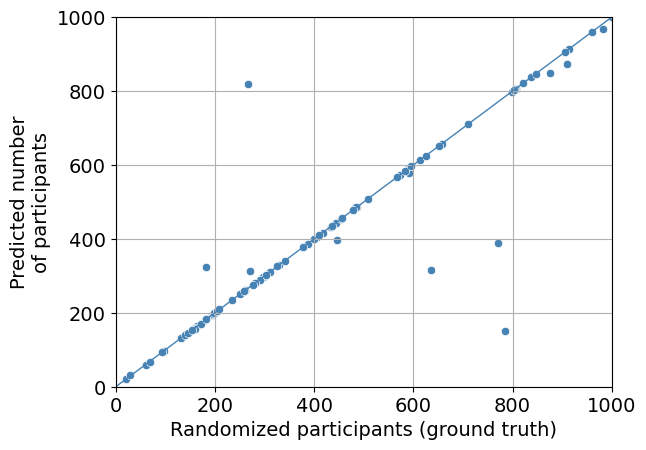

In [39]:
# Zoom in on the scatter plot
scatterplot_ordered_model_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="Number_randomized_prediction_ordered_model",
    color="steelblue",
)

scatterplot_ordered_model_zoom.set_xlim(0, 1000)
scatterplot_ordered_model_zoom.set_ylim(0, 1000)

scatterplot_ordered_model_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_ordered_model_zoom.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_ordered_model_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [40]:
# Calculate the mean absolute percentage error for the ordered model
df_test["Number_randomized_prediction_ordered_model_APE"] = (
    abs(df_test["Number_randomized_prediction_ordered_model"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)
print(
    f"Mean absolute percentage error for the ordered model: {df_test['Number_randomized_prediction_ordered_model_APE'].mean():.1%}"
)

print(f"Median absolute percentage error for the ordered model: {df_test['Number_randomized_prediction_ordered_model_APE'].median():.1%}")

Mean absolute percentage error for the ordered model: 9.2%
Median absolute percentage error for the ordered model: 0.0%


In [41]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["Number_randomized_prediction_ordered_model_WITHIN_1_PERCENT"] = df_test[
    "Number_randomized_prediction_ordered_model_APE"
] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["Number_randomized_prediction_ordered_model_WITHIN_10_PERCENT"] = df_test[
    "Number_randomized_prediction_ordered_model_APE"
] < 0.1
# Calculate the percentage of exact matches
df_test["Number_randomized_prediction_ordered_model_EXACT"] = df_test[
    "Number_randomized_prediction_ordered_model_APE"
] == 0

number_within_1_percent = df_test["Number_randomized_prediction_ordered_model_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["Number_randomized_prediction_ordered_model_WITHIN_10_PERCENT"].sum()
number_exact_matches = df_test["Number_randomized_prediction_ordered_model_EXACT"].sum()
total_trials_with_ordered_model = len(df_test[df_test["Number_randomized_prediction_ordered_model"].notnull()])
print(
    f"Percentage of extracted sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_ordered_model:.1%}"
)
print(
    f"Percentage of extracted sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_ordered_model:.1%}"
)
print(
    f"Percentage of exact matches: {number_exact_matches/total_trials_with_ordered_model:.1%}"
)


Percentage of extracted sample sizes within 1% of the ground truth: 78.2%
Percentage of extracted sample sizes within 10% of the ground truth: 87.1%
Percentage of exact matches: 76.9%


# Only accurate entities for combined prediction

In [42]:
def create_number_randomized_prediction_only_accurate(row):
    """Creates the sample size prediction based on the extracted sample sizes but only considers entities with high accuracy (RANDOMIZED_TOTAL, GENERAL_TOTAL, and ARM).

    :param row: The row of the dataframe
    :type row: pandas.core.series.Series
    :return: The predicted sample size.
    :rtype: int
    """

    randomized_total = row["RANDOMIZED_TOTAL"]
    general_total = row["GENERAL_TOTAL"]
    arms = row["ARM"]

    # Use the maximum randomized total if present
    if len(randomized_total) > 0:
        return max(randomized_total)

    # Use the sum of the arms if present
    if len(arms) > 0:
        return sum(arms)

    # Use the maximum general total if present
    if len(general_total) > 0:
        return max(general_total)

    # If no sample size is found, return None
    return None


df_test["Number_randomized_prediction_only_accurate_model"] = df_test.apply(
    create_number_randomized_prediction_only_accurate, axis=1
)

In [43]:
# Calculate how many predictions were made
print(
    f"Predicted {len(df_test[df_test['Number_randomized_prediction_only_accurate_model'].notnull()])} sample sizes."
)

# Calculate how many predictions were made in %
print(
    f"Predicted {len(df_test[df_test['Number_randomized_prediction_only_accurate_model'].notnull()]) / len(df_test) * 100:.1f}% of sample sizes."
)

Predicted 144 sample sizes.
Predicted 96.0% of sample sizes.


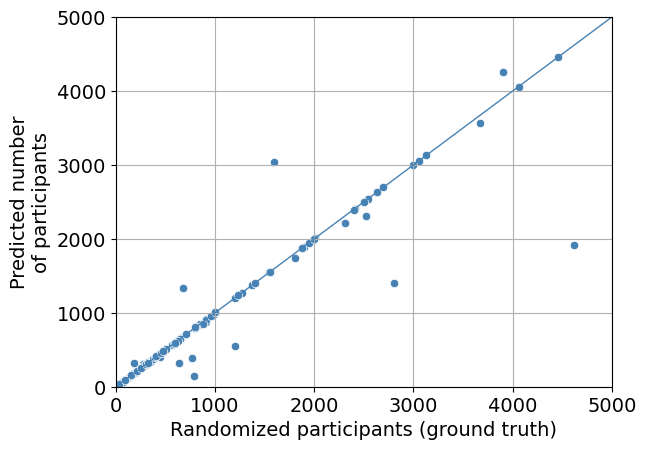

In [44]:
# Create a scatterplot for the only accurate model
scatterplot_only_accurate_model = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="Number_randomized_prediction_only_accurate_model",
    color="steelblue",
)

scatterplot_only_accurate_model.set_xlim(
    0,5000
)
scatterplot_only_accurate_model.set_ylim(
    0,5000
)

scatterplot_only_accurate_model.set_xlabel("Randomized participants (ground truth)")
scatterplot_only_accurate_model.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_only_accurate_model.png", dpi=300, bbox_inches="tight")

plt.show()

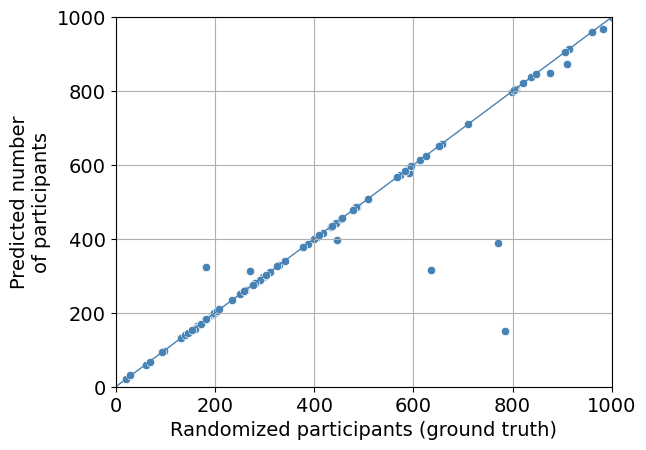

In [45]:
# Zoom in on the scatter plot
scatterplot_only_accurate_model_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="Number_randomized_prediction_only_accurate_model",
    color="steelblue",
)

scatterplot_only_accurate_model_zoom.set_xlim(0, 1000)
scatterplot_only_accurate_model_zoom.set_ylim(0, 1000)

scatterplot_only_accurate_model_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_only_accurate_model_zoom.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_only_accurate_model_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [46]:
# Calculate the mean absolute percentage error for the only accurate model
df_test["Number_randomized_prediction_only_accurate_model_APE"] = (
    abs(df_test["Number_randomized_prediction_only_accurate_model"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)

print(
    f"Mean absolute percentage error for the only accurate model: {df_test['Number_randomized_prediction_only_accurate_model_APE'].mean():.1%}"
)

print(f"Median absolute percentage error for the only accurate model: {df_test['Number_randomized_prediction_only_accurate_model_APE'].median():.1%}")

Mean absolute percentage error for the only accurate model: 7.8%
Median absolute percentage error for the only accurate model: 0.0%


In [47]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["Number_randomized_prediction_only_accurate_model_WITHIN_1_PERCENT"] = df_test[
    "Number_randomized_prediction_only_accurate_model_APE"
] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["Number_randomized_prediction_only_accurate_model_WITHIN_10_PERCENT"] = df_test[
    "Number_randomized_prediction_only_accurate_model_APE"
] < 0.1
# Calculate the percentage of exact matches
df_test["Number_randomized_prediction_only_accurate_model_EXACT_MATCH"] = df_test[
    "Number_randomized_prediction_only_accurate_model_APE"
] == 0

number_within_1_percent = df_test["Number_randomized_prediction_only_accurate_model_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["Number_randomized_prediction_only_accurate_model_WITHIN_10_PERCENT"].sum()
number_exact_matches = df_test["Number_randomized_prediction_only_accurate_model_EXACT_MATCH"].sum()

total_trials_with_only_accurate_model = len(df_test[df_test["Number_randomized_prediction_only_accurate_model"].notnull()])
print(
    f"Percentage of extracted sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_only_accurate_model:.1%}"
)
print(
    f"Percentage of extracted sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_only_accurate_model:.1%}"
)
print(
    f"Percentage of exact matches: {number_exact_matches/total_trials_with_only_accurate_model:.1%}"
)


Percentage of extracted sample sizes within 1% of the ground truth: 79.9%
Percentage of extracted sample sizes within 10% of the ground truth: 88.2%
Percentage of exact matches: 78.5%


# Conditional model

In [48]:
def create_number_randomized_prediction_conditional(row):
    """Creates the sample size prediction based on the extracted sample sizes but only considers entities with high accuracy with additional criteria.

    :param row: The row of the dataframe
    :type row: pandas.core.series.Series
    :return: The predicted sample size.
    :rtype: int
    """

    randomized_total = row["RANDOMIZED_TOTAL"]
    general_total = row["GENERAL_TOTAL"]
    arms = row["ARM"]

    # Use the maximum randomized total if present
    if len(randomized_total) > 0:
        return max(randomized_total)

    # Use the general total only if arms are also present and if they are within 10% of each other
    if len(general_total) > 0 and len(arms) > 0:
        if (
            sum(arms) / max(general_total) < 1.1
            and sum(arms) / max(general_total) > 0.9
        ):
            return max(general_total)

    # If no sample size is found, return None
    return None


df_test["Number_randomized_prediction_conditional_model"] = df_test.apply(
    create_number_randomized_prediction_conditional, axis=1
)

In [49]:
# Calculate how many predictions were made
print(
    f"Predicted {len(df_test[df_test['Number_randomized_prediction_conditional_model'].notnull()])} sample sizes."
)

# Calculate how many predictions were made in %
print(
    f"Predicted {len(df_test[df_test['Number_randomized_prediction_conditional_model'].notnull()]) / len(df_test) * 100:.1f}% of sample sizes."
)

Predicted 97 sample sizes.
Predicted 64.7% of sample sizes.


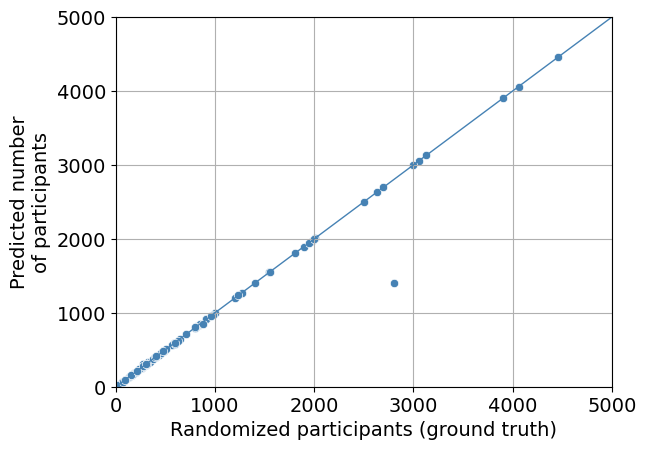

In [50]:
# Create a scatterplot for the conditional model
scatterplot_conditional_model = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="Number_randomized_prediction_conditional_model",
    color="steelblue",
)

scatterplot_conditional_model.set_xlim(
    0,5000
)
scatterplot_conditional_model.set_ylim(
    0,5000
)

scatterplot_conditional_model.set_xlabel("Randomized participants (ground truth)")
scatterplot_conditional_model.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_conditional_model.png", dpi=300, bbox_inches="tight")

plt.show()

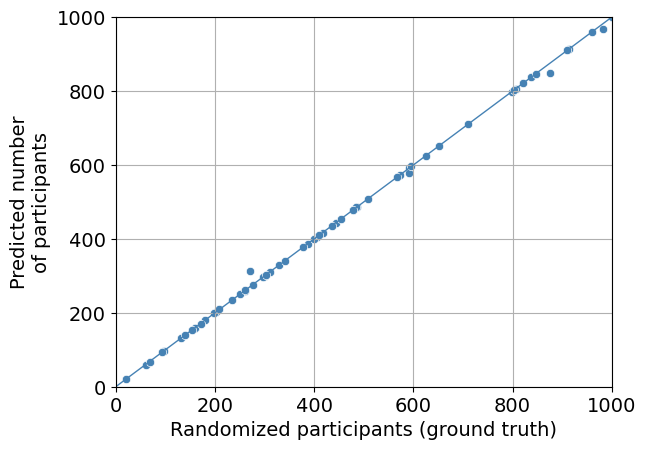

In [51]:
# Zoom in on the scatter plot
scatterplot_conditional_model_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="Number_randomized_prediction_conditional_model",
    color="steelblue",
)

scatterplot_conditional_model_zoom.set_xlim(0, 1000)
scatterplot_conditional_model_zoom.set_ylim(0, 1000)

scatterplot_conditional_model_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_conditional_model_zoom.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_conditional_model_zoom.png", dpi=300, bbox_inches="tight")

plt.show()

In [52]:
# Calculate the mean absolute percentage error for the conditional model
df_test["Number_randomized_prediction_conditional_model_APE"] = (
    abs(df_test["Number_randomized_prediction_conditional_model"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)

print(
    f"Mean absolute percentage error for the conditional model: {df_test['Number_randomized_prediction_conditional_model_APE'].mean():.1%}"
)

print(f"Median absolute percentage error for the conditional model: {df_test['Number_randomized_prediction_conditional_model_APE'].median():.1%}")

Mean absolute percentage error for the conditional model: 1.7%
Median absolute percentage error for the conditional model: 0.0%


In [53]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["Number_randomized_prediction_conditional_model_WITHIN_1_PERCENT"] = df_test[
    "Number_randomized_prediction_conditional_model_APE"
] < 0.01
# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["Number_randomized_prediction_conditional_model_WITHIN_10_PERCENT"] = df_test[
    "Number_randomized_prediction_conditional_model_APE"
] < 0.1
# Calculate the percentage of exact matches
df_test["Number_randomized_prediction_conditional_model_EXACT"] = df_test[
    "Number_randomized_prediction_conditional_model_APE"
] == 0

number_within_1_percent = df_test["Number_randomized_prediction_conditional_model_WITHIN_1_PERCENT"].sum()
number_within_10_percent = df_test["Number_randomized_prediction_conditional_model_WITHIN_10_PERCENT"].sum()
number_exact = df_test["Number_randomized_prediction_conditional_model_EXACT"].sum()
total_trials_with_conditional_model = len(df_test[df_test["Number_randomized_prediction_conditional_model"].notnull()])

print(
    f"Percentage of extracted sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_conditional_model:.1%}"
)
print(
    f"Percentage of extracted sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_conditional_model:.1%}"
)
print(
    f"Percentage of exact matches: {number_exact/total_trials_with_conditional_model:.1%}"
)

Percentage of extracted sample sizes within 1% of the ground truth: 93.8%
Percentage of extracted sample sizes within 10% of the ground truth: 96.9%
Percentage of exact matches: 93.8%
